# Interpreting a model
----
A very important step in tuning a model and getting an understanding of what it is doing is the so-called model interpretability. I.e. understanding why a model makes specific decisions.

Captum is a package we can use to gain understanding of how various features and feature values atttributed to an outcome of a Pytorch model. This notebook will show some basic examples. 

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from typing import List, Tuple

from captum.attr import IntegratedGradients

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create our Dummy file again

If is wasn't clear before, note that most of this file is random, but the way we assign the **fraud** flag is not. If we want our model to learn something, the fraud flag can ofcourse not be random, our model would not understand what is going on if it where. See;

`Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0`

We might rightfully assume that above logic should in some shape or form be visible in the feature attributions. For instance country 'FR' and 'NL' should normally have strong attributions for the fraud cases.

Just so as to prove the point, this file also contains a **random number** the `Noise` feature that is in no shape or form related to the *fraud* label. We might assume that the attribution of this feature would look differently than the other feature that clearly attribute to the *fraud* label

In [2]:
header = 'Date,Amount,Noise,Card,Merchant,MCC,Country,Fraud\n'
file = './data/bigger_card.csv'

MCC_LIST = [f'{i:04d}' for i in range(25)] # Create 25 MCC-Codes
MCC_PROB = list(np.random.random(len(MCC_LIST)))
MCC_PROB = [p/sum(MCC_PROB) for p in MCC_PROB]

Country_LIST = ['FR', 'DE', 'GB', 'NL', 'ES', 'IT', 'SE', 'PL', 'CH'] # Create 9 country codes
Country_PROB = list(np.random.random(len(Country_LIST)))
Country_PROB = [p/sum(Country_PROB) for p in Country_PROB]

number_of_records = 10000

with open(file, 'w') as f:
    f.write(header)
    for i in range(number_of_records):
        # Dates in range 1st till 30th of January, increasing.
        date = f'202001{int((i/(number_of_records/30))+1):02d}'
        # Random normally distributed amount. Mean 100, stddev 30. Rounded to 2 decimals.
        amount = np.around(np.random.normal(100, 30, 1), 2).item()
        # Create noise feature
        noise = np.around(np.random.random_sample(),2)
        # Create a random card nr 0 to 50
        card_nr = np.random.randint(50)
        # Select an MCC, draw from MCC List accoring to MCC_PROB probability distribution.
        MCC = np.random.choice(MCC_LIST, 1, p=MCC_PROB).item()
        # Select an MCC, draw from Country List accoring to County_PROB probability distribution.
        Country = np.random.choice(Country_LIST, 1, p=Country_PROB).item()
        # Assign some Fraud, this can not be random if we the model to learn something.
        Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0
        # Make row and write.
        row = f'{date},{amount},{noise},CARD-{card_nr},MRC-{MCC},{MCC},{Country},{Fraud}\n'
        f.write(row)

## Create our features and data-set

In [3]:
amount  = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
noise  = ft.FeatureSource('Noise', ft.FEATURE_TYPE_FLOAT_32)
mcc     = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud   = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled, noise])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_amount, td_oh, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

cpu        = torch.device('cpu')
batch_size = 32

train_sampler = mp.TensorInstanceNumpyLabelSampler(train).over_sampler()

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

2023-04-09 20:50:04.741 eng1n3.common.engine           INFO     Start Engine...
2023-04-09 20:50:04.741 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-09 20:50:04.742 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-09 20:50:04.742 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/bigger_card.csv
2023-04-09 20:50:04.752 e...renormalizescaleprocessor  INFO     Create Scaled_Amount Scale Amount. Min. -6.94 Max. 208.11
2023-04-09 20:50:04.753 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-09 20:50:04.753 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


## Model

Create our model again, it should be fairly similar by now.

In [4]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(FirstModel, self).__init__(tensor_instance)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # One Linear Layer that maps the output of the heads, size 37 to size 1.
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a LIST of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

#Create a 'FirstModel' instance
model = FirstModel(train)
model

FirstModel(
  Number of parameters : 37. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
    (1): TensorDefinitionHead(Name=Features_OH, lc=Binary)
  )
  (l1): Linear(in_features=36, out_features=1, bias=True)
  (tail): Sigmoid()
)

## Train our model again
Train the model and plot the training history.

In [5]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.1)
# Run the trainer for 5 epochs
history = trainer.train(5, optimizer)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 1115.46it/s, t_loss=0.0304, t_acc=0.994, v_loss=0.0329, v_acc=0.989]     


## Call captum
Captum has a wide variety of algorithms to calculate the attribution of features, see the documentation for more info; [Captum APi](https://captum.ai/api/). The m0d3l package has a helper function that takes care of the tricky bit. And it is a bit tricky, embeddings need to be handled specifically, you need a specific forward function because captum unpacks the tuples of tensors you feed as input, etc...

Long story short, it is possible to run attribution algo rithms that have a signature `class
captum.attr.<captum_algo>(forward_func)`. If the algorithm takes other input, then you'll need to write a custom funtion.

Below cell gets the Attributions for our `model` instance, using the `IntegratedGradients` attribution algorithm and it uses the first `1000 records of the test data-set`

In [6]:
attr = cp.CaptumAttributions.get_attributions_binary(model, IntegratedGradients, test_ds[0:1000])

Once we have the attributions we can call various plot functions.

The first one is a violin plot of attributions of each input feature. Violin plots don't only show the minimum and maximum attributions, but also give an idea of the density distribution. 

Mostly when you run this, you'll see something like below. 
- The amount attribution starts at 0, it never gets negative, but overall has lower contributions than the OH features
- Both OH features seen to mostly attribute negatively, but there are occasions where attribute a lot (most likely for the values we set in the fraud condition.
- The noise feature has a very flat distribution it seem to main attribute very low values. Though it does seem to contribute negative values in some case, we can see t his from the whister pointing down.

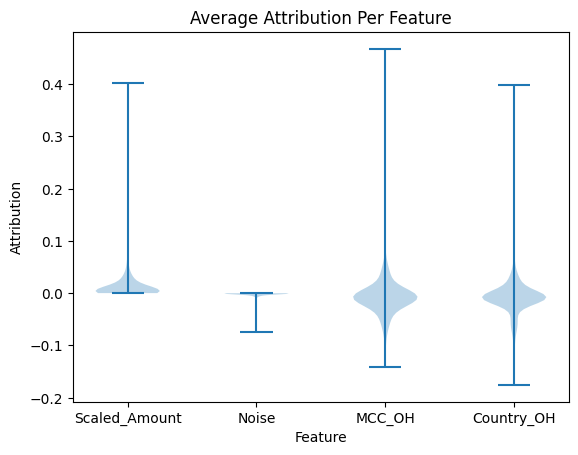

In [7]:
mplt.AttributionPlotBinary.overview(attr)

It is also possible to get the detail of a specific feature. For continous features a scatter plot is quite informative, it plots the values of the feature on the X-axis and the attribution on the Y-axis. 

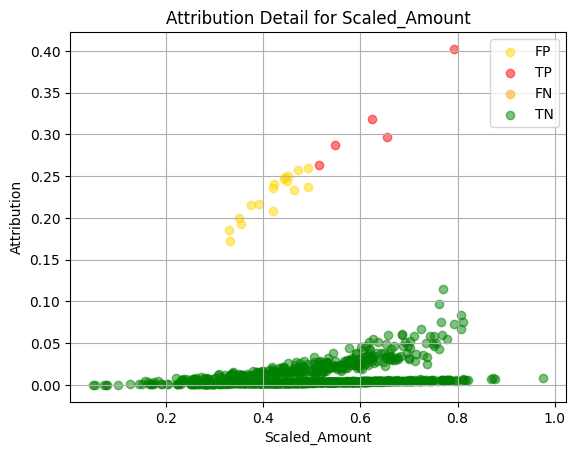

In [8]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_scaled)

For categorical values the detail show the **average** contribution per value in the sample.

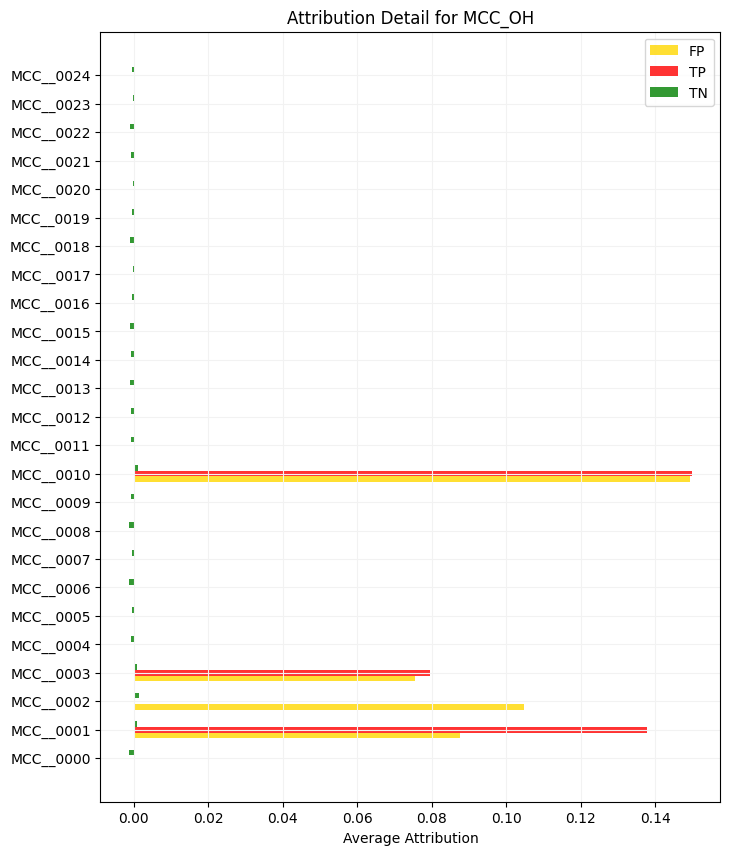

In [9]:
mplt.AttributionPlotBinary.feature_detail(attr, mcc_oh, fig_size=(8,10))

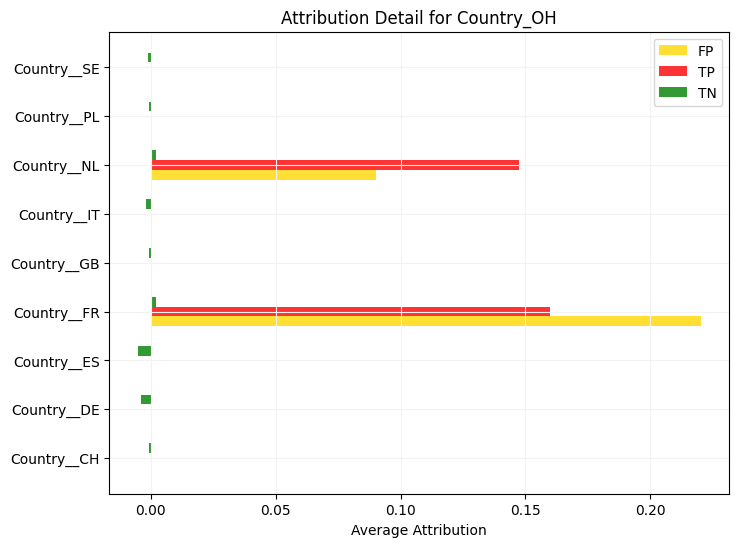

In [10]:
mplt.AttributionPlotBinary.feature_detail(attr, country_oh, fig_size=(8,6))

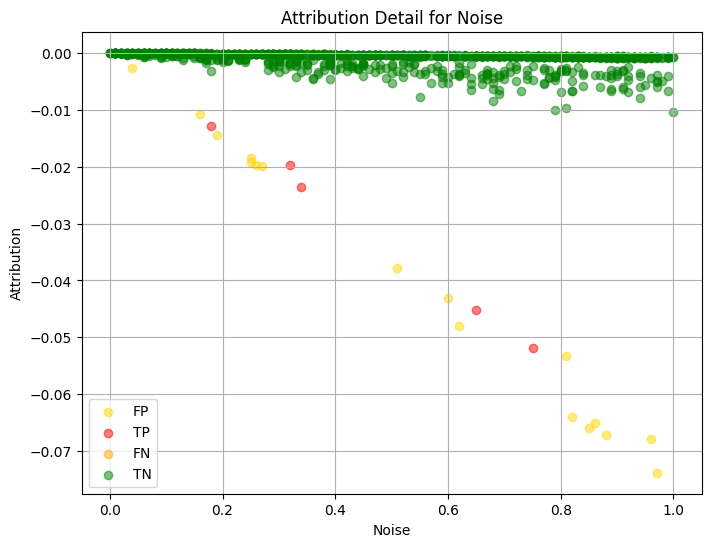

In [11]:
mplt.AttributionPlotBinary.feature_detail(attr, noise, fig_size=(8,6))

It is also possible to show the contributions on a heatmap. The heatmap show the original value of the data in the text and the colordepth indicates the attribution. The color of the text show the classification result. It indicates if the sample was True Positive, False Positive, False Negative or True Negative.

We'll make the sample slightly smaller for this test.

In [16]:
attr = cp.CaptumAttributions.get_attributions_binary(model, IntegratedGradients, test_ds[0:20])

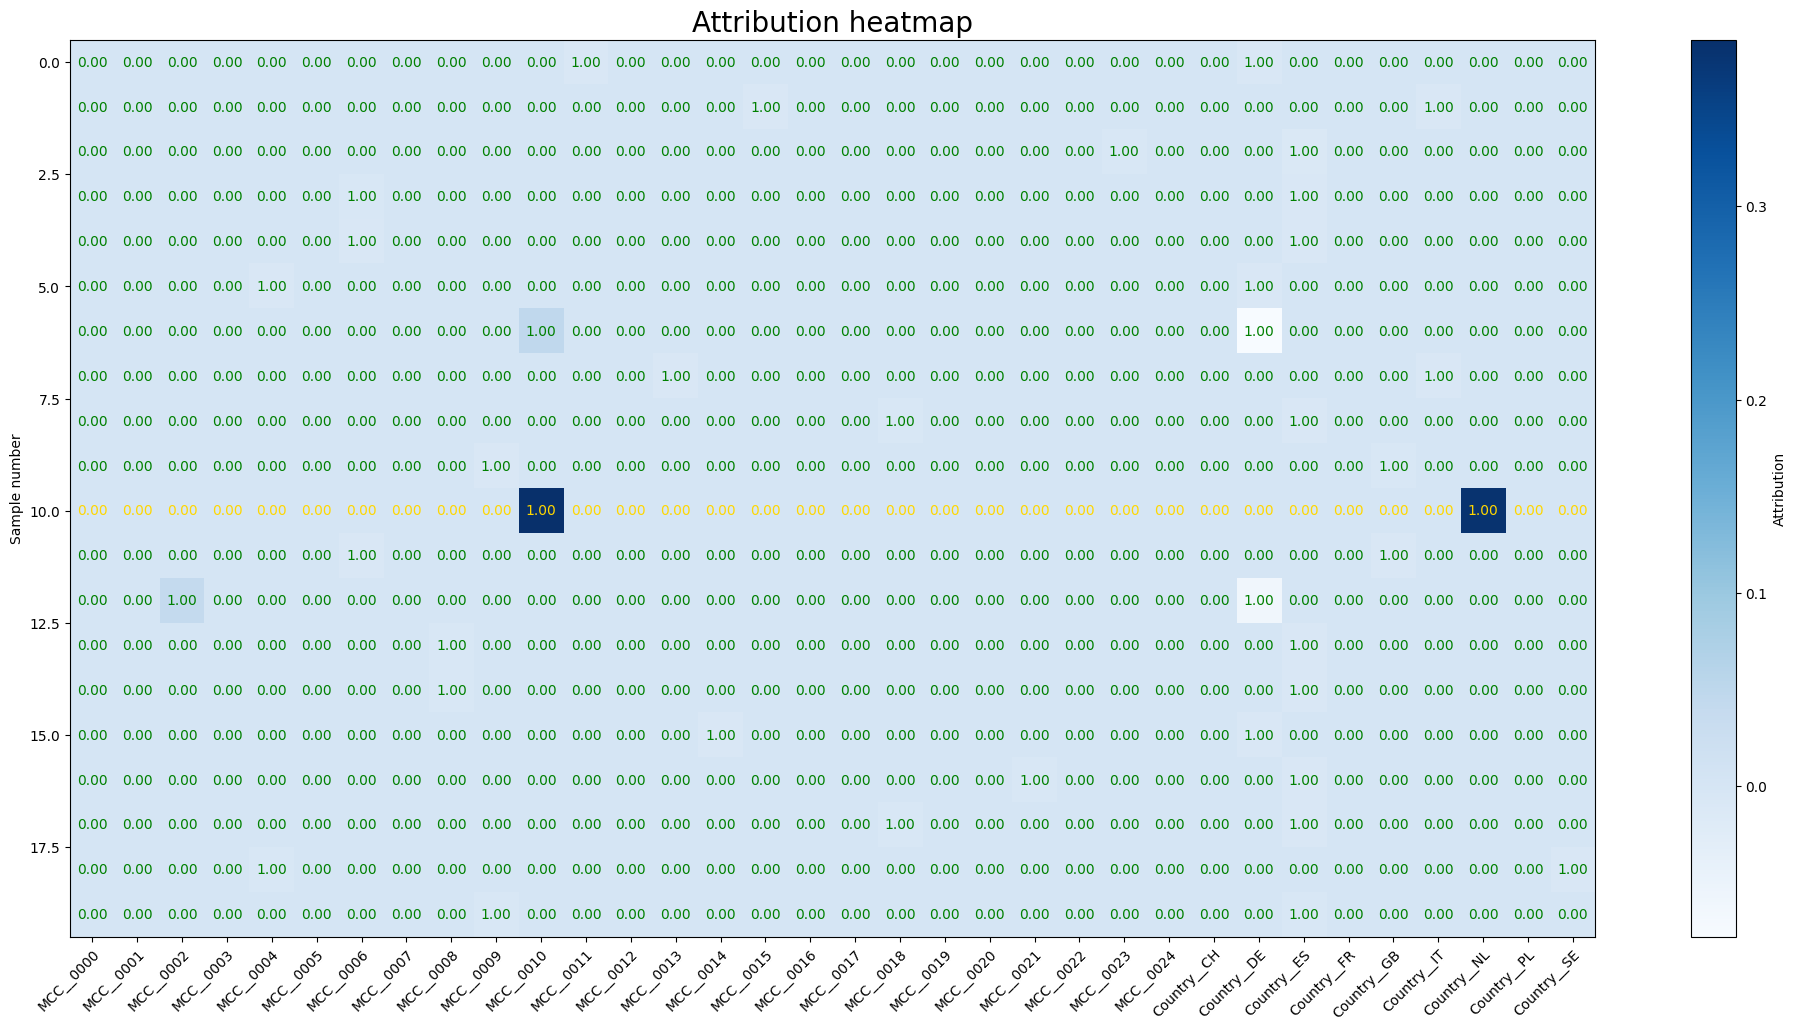

In [17]:
mplt.AttributionPlotBinary.heatmap(attr, td_oh, fig_size=(20,10), font_size=10)

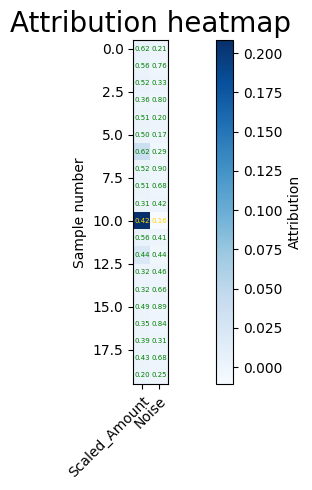

In [18]:
mplt.AttributionPlotBinary.heatmap(attr, td_amount, fig_size=(10,5), font_size=5)

Clean-up after ourselves. Delete our test file.

In [19]:
!rm $file

## Conslusion